In [32]:
from langgraph.graph import StateGraph, END, START
from langchain_google_genai import ChatGoogleGenerativeAI
from typing import TypedDict, Annotated, Literal
from dotenv import load_dotenv
import os
from pydantic import BaseModel, Field

In [33]:
load_dotenv()

True

In [34]:
model = ChatGoogleGenerativeAI(
    model = 'gemini-2.5-flash',
    google_api_key = os.getenv('GEMINI_API_KEY')
)

E0000 00:00:1759599120.177263 3612311 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


In [35]:
class SentimentSchema(BaseModel):

    sentiment: Literal["positive", "negative"] = Field(description="Specify the sentiment of the given review")

In [36]:
class DiagnosisSchema(BaseModel):
    issue_type: Literal["UX", "Performance", "Bug", "Support", "Other"] = Field(
        description="The type of issue reported by the user."
    )
    tone: Literal["angry", "frustrated", "disappointed", "calm"] = Field(
        description="The emotional tone expressed by the user."
    )
    urgency: Literal["low", "medium", "high"] = Field(
        description="How urgent or critical the issue is."
    )


In [37]:
structured_model = model.with_structured_output(SentimentSchema)
structured_model2 = model.with_structured_output(DiagnosisSchema)

In [38]:
# prompt = "What is the sentiment of the following review: The software is very glitchy"
# structured_model.invoke(prompt).sentiment

In [39]:
class ReviewState(TypedDict):

    review: str
    sentiment : Literal["positive", "negative"]
    diagnosis : dict
    #This is going to be a dictionary where we will be storing the 3 parameters for diagnosis
    response : str

In [40]:
def find_sentiment( state: ReviewState ) -> ReviewState:

    rev = state['review']
    prompt = f"What is the sentiment of the following review: {rev}"
    sentiment = structured_model.invoke(prompt).sentiment

    return { 'sentiment': sentiment}

In [41]:
def check_sentiment( state : ReviewState) -> Literal["positive_response", "run_diagnosis"]:

    if state["sentiment"] == 'positive':
        return "positive_response"
    else:
        return "run_diagnosis"


In [42]:
def positive_response( state : ReviewState) -> ReviewState:

    prompt = f"""Write a warm thank-you message in response to this review:
    \n\n"{state['review']}"\n
    Also, kindly ask the user to leave feedback on our website"""


In [43]:
def run_diagnosis(state: ReviewState):
    prompt = f"""Diagnose this negative review:\n\n{state['review']}\n
    Return issue_type, tone, and urgency.
    """
    response = structured_model2.invoke(prompt)
    return {'diagnosis': response.model_dump()}


In [44]:
def negative_response( state : ReviewState):
    prompt = """You are a support assistant.
    The user had a '{diagnosis['issue_type']}' issue, sounded '{diagnosis['tone']}', and marked urgency as '{diagnosis['urgency']}'.
    Write an empathetic, helpful resolution message."""

    response = model.invoke(prompt).content

    return {'response': response}

In [45]:
graph = StateGraph(ReviewState)

graph.add_node('find_sentiment', find_sentiment)
graph.add_node('run_diagnosis', run_diagnosis)
graph.add_node('positive_response', positive_response)
graph.add_node('negative_response', negative_response)

graph.add_edge(START, 'find_sentiment')
graph.add_conditional_edges('find_sentiment', check_sentiment)
graph.add_edge('positive_response', END)
graph.add_edge('run_diagnosis', 'negative_response')
graph.add_edge('negative_response', END)

workflow = graph.compile()




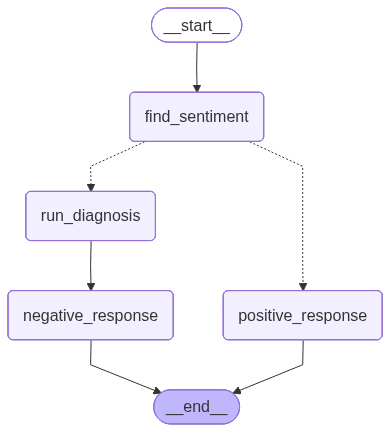

In [46]:
workflow

In [47]:
initial_state = {
    'review' : 'The product is really bad'
}

workflow.invoke(initial_state)

{'review': 'The product is really bad',
 'sentiment': 'negative',
 'diagnosis': {'issue_type': 'Other',
  'tone': 'disappointed',
  'urgency': 'low'},
 'response': "Hello there,\n\nWe understand you've been experiencing a **{diagnosis['issue_type']}** issue. We heard your concern, and it's clear from your **{diagnosis['tone']}** tone, coupled with marking the urgency as **{diagnosis['urgency']}**, that this was a priority for you. We sincerely apologize for any frustration or inconvenience this may have caused.\n\nWe're pleased to inform you that we've successfully addressed your request/resolved the issue.\n\nPlease check [specific area or action, e.g., your account, your email, the system] to confirm everything is now to your satisfaction. If you encounter any further difficulties or have additional questions, please don't hesitate to reach out. We're here to help!\n\nThank you for your patience and understanding.\n\nBest regards,\n\nYour Support Team"}